In [159]:
import os
import sys

from math import cos,sin,tan,asin,acos,radians,sqrt,degrees,atan,atan2,copysign
import numpy as np

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle
import scipy
from scipy.stats import norm
import random
import time
import timeit
import math
import localization as lx
import gzip

import util.npose_util as nu
import datetime
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree

import tensorflow as tf
import joblib
from sklearn.manifold import MDS
import argparse
from functools import partial
from itertools import starmap,repeat,permutations,combinations

from pymol import cmd, stored, selector

import GenerateEndpoints as ge
import HelixFit as hf
import FitTransform as ft

import seaborn as sns
import util.RotationMethods as rm

#reference helix for propogation
zero_ih = nu.npose_from_file('util/zero_ih.pdb')
tt = zero_ih.reshape(int(len(zero_ih)/5),5,4)
stub = tt[7:10].reshape(15,4)

np.set_printoptions(precision=2)
%config Completer.use_jedi = False

In [2]:
#load distance maps
def load_distance_map(name, dm_file='data/Fits_4H_dm_phi.npz'):
    rr = np.load(dm_file, allow_pickle=True)
    X_train, y_train , featNames = [rr[f] for f in rr.files]
    
    
    return X_train[y_train==name][:,:-4]


In [3]:
# dm_file = 'data/Fits_4H_dm_phi.npz'
# rr = np.load(dm_file, allow_pickle=True)
# X_train, y_train , featNames = [rr[f] for f in rr.files]

In [4]:
model_direc = 'data/4H_dataset/models/'
# cmd.load(f'{model_direc}{y_train[0]}.pdb')

# cmd.save(f'output/test.pdb')

In [5]:
#endpoints for data set 
Fits4H_file = 'data/Fits_4H.csv'
dfRead = pd.read_csv(Fits4H_file)
df1 = ft.prepData_Str(dfRead,rmsd_filter=100)
df2 = ft.EndPoint(df1)
ep = df2.to_numpy()[:,:24].astype(float).reshape((-1,8,3))
X = ep

In [9]:
def index_helix_ep(ep_in,helices_desired=[0,1],num_helices=4):
    
    num_ep = num_helices*2
    hi = np.array(helices_desired,dtype=int)
    h_ep = np.array(range(num_ep)).reshape((-1,2)) #generate helix to endpoint mapping
    
    #alternate example for indexing batch of X 
    #X.reshape((X.shape[0],-1))[:,indexarray]
    
    #select desired endpoints from  batch of endpoints
    return X[np.ix_(np.array(range(ep_in.shape[0])),h_ep[hi].flatten(), np.array(range(ep_in.shape[2])))]
    
def get_midpoint(ep_in,helices_desired=[0,1],num_helices=4):
    
    num_ep = num_helices*2
    
    ind_ep = index_helix_ep(ep_in, helices_desired=helices_desired, num_helices=4)
    
    #calculate midpoint
    midpoint = ind_ep.sum(axis=1)/np.repeat(ind_ep.shape[1], ind_ep.shape[2])
    
    return midpoint
    
    
    
    

In [68]:
#distance map and midpoint calculation of dataset

#distance map of ep dataset
#unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
dX = np.expand_dims(X,axis=1) - np.expand_dims(X,axis=2)
dist = np.sqrt(np.sum(dX**2, 3))  #+ 1e-6) #this dataset is good 
dist = dist.reshape((dist.shape[0],-1))

mp_01 = get_midpoint(X,helices_desired=[0,1])
mp_23 = get_midpoint(X,helices_desired=[2,3])
# d= np.linalg.norm(mp_02-mp_01,axis=1)
# sns.histplot(d)

#mp distance map
ep_mp = np.hstack((X.reshape((-1,24)),mp_01,mp_23)).reshape(-1,10,3) #helix12mp=8  helix34mp=9
#unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
dep_mp = np.expand_dims(ep_mp,axis=1) - np.expand_dims(ep_mp,axis=2)
dist_mp = np.sqrt(np.sum(dep_mp**2, 3))  #+ 1e-6) #this dataset is good 

In [8]:
#https://en.wikipedia.org/wiki/Cayley%E2%80%93Menger_determinant

In [249]:
def tet_start():
    """Generate all tetrahedrons between endpoints of helices 1/2 to 3/4 and then 3/4 to 1/2"""
    tetra_ind = []
    for x in combinations((range(4)),3):
        for y in range(4):
            tetra_ind.append(list(x))
            tetra_ind[-1].append(y+4)

    for x in combinations((range(4,8)),3):
        for y in range(4):
            tetra_ind.append(list(x))
            tetra_ind[-1].append(y)
    return np.array(tetra_ind)

def tetrahedron_index(dm_points,num_helices=4, ret_upperInd=False):
    """Convert index of points into indexing output distances of generator """
    #prep indices for distance map
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    tot_ind = []
    
    for x in permutations(dm_points,2): 
        # permutations means I don't have to worry about order of points/
        # indexing the lower half of the distance map
        new_ind = np.intersect1d(mat_ind[x[0]], mat_ind.T[x[1]])
        tot_ind.extend(new_ind)
    
    upperInd = np.intersect1d(tot_ind,mat_ind[iu1])
    #print(upperInd)
    if ret_upperInd:
        return upperInd
    
    out_ind = []
    for x in upperInd.flatten():
        out_ind.append(np.nonzero(mat_ind[iu1]==x))
        
    out_ind = np.array(out_ind)
    
    return out_ind.flatten()

In [144]:
# for help checking indices
# num_helices=4
    
# #prep indices for distance map
# num_ep = num_helices*2
# mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
# iu1 = np.triu_indices(num_ep, 1)
# il1 = np.tril_indices(num_ep, 1)
# print(mat_ind)

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]]


In [250]:
tetraind = []
ti_p = tet_start()

for x in ti_p:
    tetraind.append(tetrahedron_index(x,ret_upperInd=True))
ti = np.array(tetraind)



In [253]:
all_tets = dist[:,ti]

In [268]:
all_tets.shape

(27877, 32, 6)

In [264]:
a=np.ones((5,5))
np.fill_diagonal(a, 0)
a =np.repeat(np.expand_dims(a,axis=0), all_tets.shape[1],axis=0)
a =np.repeat(np.expand_dims(a,axis=0), all_tets.shape[0],axis=0)

In [266]:
a.shape

(27877, 32, 5, 5)

In [371]:
iu1_mod1 = np.array(np.triu_indices(4,1))
iu1_mod1 += 1


il1_mod1 = np.array(np.tril_indices(4,-1))
il1_mod1 += 1

iu1_mod1 = tuple(iu1_mod1)
il1_mod1 = tuple(il1_mod1)

a[:,:,iu1_mod1[0],iu1_mod1[1]] = np.square(all_tets)
a[:,:,il1_mod1[0],il1_mod1[1]] = np.transpose(a,axes=(0,1,3,2))[:,:,il1_mod1[0],il1_mod1[1]]


In [373]:
np.sqrt(np.linalg.det(a)/288)

array([[332.04, 258.15, 213.93, ..., 208.92, 263.39,  54.01],
       [430.81, 188.44, 234.02, ..., 227.42, 313.65,  30.15],
       [144.36, 278.68, 231.94, ..., 154.6 , 199.8 , 334.02],
       ...,
       [ 96.1 , 264.97, 225.49, ..., 144.42, 120.63,  77.55],
       [219.  , 234.24, 249.47, ..., 169.07, 110.8 ,  48.75],
       [134.61, 289.68, 289.81, ..., 207.09, 169.66, 124.41]])

In [362]:
a[0]

array([[[ 0.  ,  1.  ,  1.  ,  1.  ,  1.  ],
        [ 1.  ,  0.  , 16.61, 13.77, 15.53],
        [ 1.  , 16.61,  0.  , 10.4 , 27.14],
        [ 1.  , 13.77, 10.4 ,  0.  , 23.31],
        [ 1.  , 15.53, 27.14, 23.31,  0.  ]],

       [[ 0.  ,  1.  ,  1.  ,  1.  ,  1.  ],
        [ 1.  ,  0.  , 16.61, 13.77, 21.25],
        [ 1.  , 16.61,  0.  , 10.4 , 13.24],
        [ 1.  , 13.77, 10.4 ,  0.  , 12.38],
        [ 1.  , 21.25, 13.24, 12.38,  0.  ]],

       [[ 0.  ,  1.  ,  1.  ,  1.  ,  1.  ],
        [ 1.  ,  0.  , 16.61, 13.77, 17.59],
        [ 1.  , 16.61,  0.  , 10.4 ,  9.16],
        [ 1.  , 13.77, 10.4 ,  0.  , 13.78],
        [ 1.  , 17.59,  9.16, 13.78,  0.  ]],

       [[ 0.  ,  1.  ,  1.  ,  1.  ,  1.  ],
        [ 1.  ,  0.  , 16.61, 13.77, 11.19],
        [ 1.  , 16.61,  0.  , 10.4 , 21.72],
        [ 1.  , 13.77, 10.4 ,  0.  , 21.74],
        [ 1.  , 11.19, 21.72, 21.74,  0.  ]],

       [[ 0.  ,  1.  ,  1.  ,  1.  ,  1.  ],
        [ 1.  ,  0.  , 16.61, 19.02, 15.53],
  

In [338]:
all_tets.shape

(27877, 32, 6)

In [322]:
a[:,iu1_mod1] =  all_tets

a[:,il1_mod1] = a.T[:,il1_mod1]

ValueError: shape mismatch: value array of shape (27877,32,6) could not be broadcast to indexing result of shape (32,2,6,27877,5,5)

In [235]:

a[iu1_mod1] =  ti[0]

a[il1_mod1] = a.T[il1_mod1]

a

array([[ 0.,  1.,  1.,  1.,  1.],
       [ 1.,  0., 19., 20., 21.],
       [ 1., 19.,  0., 25., 26.],
       [ 1., 20., 25.,  0., 27.],
       [ 1., 21., 26., 27.,  0.]])

In [231]:
il1_mod1

(array([2, 3, 3, 4, 4, 4], dtype=int64),
 array([1, 1, 2, 1, 2, 3], dtype=int64))

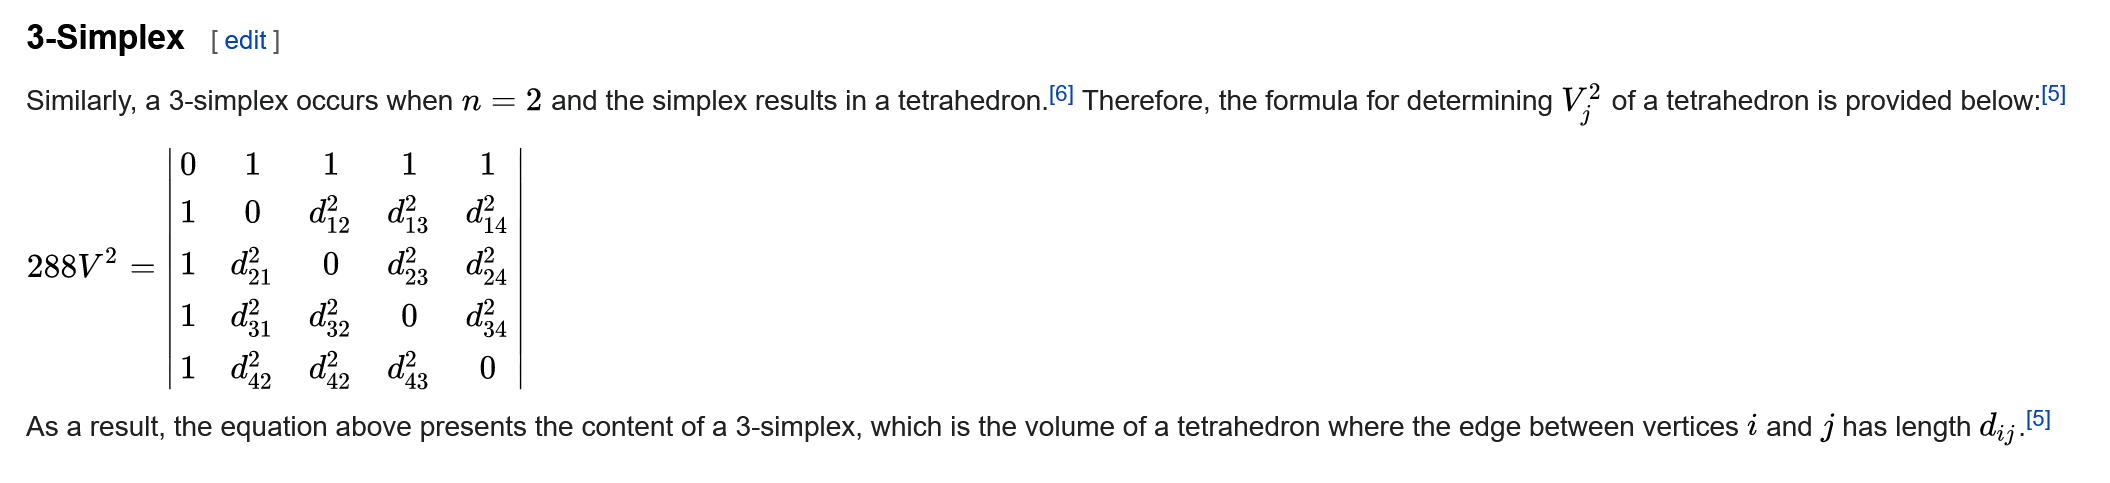

In [177]:
a=np.ones((5,5))
np.fill_diagonal(a, 0)

In [179]:
a

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0.]])

In [12]:
#apply 3 base points to z plane for simplicity
#in my case lets start with point indices 1,2,3

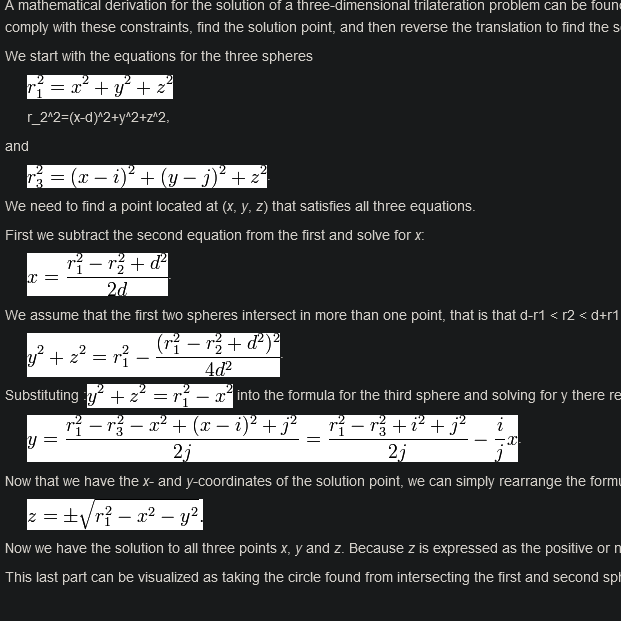

In [79]:
def get_stubs_from_points(ep_in,index=[0,1,2]):
#def get_stubs_from_n_ca_c(n, ca, c):
    """Modified from Brian's npose code  get_stubs_from_n_ca_c, index references 3 points, to define plane.
    """
    e1 = ep_in[:,index[1]]-ep_in[:,index[0]]
    e1 = np.divide( e1, np.linalg.norm(e1, axis=1)[..., None] )

    e3 = np.cross( e1, ep_in[:,index[2]]-ep_in[:,index[0]], axis=1 )
    e3 = np.divide( e3, np.linalg.norm(e3, axis=1)[..., None] )

    e2 = np.cross( e3, e1, axis=1 )

    stub = np.zeros((len(ep_in), 4, 4))
    stub[...,:3,0] = e1
    stub[...,:3,1] = e2
    stub[...,:3,2] = e3
    stub[...,:3,3] = ep_in[:,index[1]]
    stub[...,3,3] = 1.0

    return stub

def xform_npose_2batch(xform, npose):
    return np.matmul(np.repeat(xform[:,np.newaxis,...],npose.shape[1],axis=1),npose[...,None]).squeeze(-1)



def xform_to_z_plane(mobile, index_mobile=[0,1,2]):
    """rotate points into the z-plane for trilaterization"""

    mobile_stub = get_stubs_from_points(mobile, index=index_mobile)
    mobile_stub_inv = np.linalg.inv(mobile_stub)
    
    z_plane_ref = np.repeat(np.array([[[0,0,0],[1,0,0],[1,1,0]]]), mobile.shape[0],axis=0)

    ref_stub = get_stubs_from_points(z_plane_ref, index=[0,1,2])

    xform = ref_stub @ mobile_stub_inv

    return xform

#dindex=[14,24,34,12,23,13] # example for targetpoint 4

def target_dindex(target_point, oneRef = True, num_helices = 5):
    
    if oneRef:
        ref = [1,2,3]
        base_tri = [12,23,13] 
    else:
        ref = [0,1,2]
        base_tri = [1,12,3] 
    
    
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    
    dindex = mat_ind[ref,target_point] #indices for distances to target point
    
    return np.hstack((dindex,base_tri))



def tetrahedron_points_from_distance_map(distance_map, target_point, oneRef=True):

    dmap = distance_map.reshape((distance_map.shape[0],-1))
    dindex = target_dindex(target_point, oneRef = oneRef, num_helices = 5) #num_helices is 4+ (1 [2xmidpoint])
    
    #radius of spheres for trilaterization, distance of base triangle to target point
    r1 = dmap[:,dindex[0]].reshape((-1,1))
    r2 = dmap[:,dindex[1]].reshape((-1,1))
    r3 = dmap[:,dindex[2]].reshape((-1,1))
    print('dindex', dindex)
    print('r1', r1)
    print('r2', r2)
    print('r3', r3)
    print('r12', r1**2)
    print('r22', r2**2)
    print('r32', r3**2)

    dvar = dmap[:,dindex[3]].reshape(-1,1)
    p1 = np.repeat(np.array([[0,0,0]]),dmap.shape[0],axis=0)
    p2 = np.zeros_like(p1)
    p2[:,0] = dvar.flatten()

    #calculate the opposite angle of the the third side using law of cosines
    s1sq = np.square(dvar).reshape((-1,1))
    s2sq = np.square(dmap[:,dindex[5]]).reshape((-1,1))
    s3sq = np.square(dmap[:,dindex[4]]).reshape((-1,1))
    ang3= np.arccos((-s3sq+s2sq+s1sq)/(2*dvar*(dmap[:,dindex[5]]).reshape((-1,1))))
    print('ang3',ang3)

    #take third point of base triangle via angle to vector
    v13 = np.concatenate([np.cos(ang3), np.sin(ang3), np.zeros_like(ang3)], axis=1)
    print('v13',v13)
    p3 = dmap[:,dindex[5]].reshape((-1,1))*v13
    print('p3',p3)
    #center points of 3rd sphere
    ivar = p3[:,0].reshape((-1,1))
    jvar = p3[:,1].reshape((-1,1))
    print('ivar',ivar)
    print('jvar',jvar)
    print('dvar',dvar)
    
    #3equations 3 varibales solving for circles
    x = (r1**2-r2**2+dvar**2)/(2*dvar)
    y = (r1**2-r3**2+ivar**2+jvar**2)/(2*jvar)-(ivar/jvar)*x
    z = np.sqrt(r1**2-x**2-y**2) # z can be plus or mins, important for midpoint 
    print('x',x)
    print('y',y)
    print('z',z)

    return np.concatenate((x,y,z),axis=1)

In [80]:
di = target_dindex(4, oneRef = True, num_helices = 5)

In [81]:
def rotate_base_tri_Zplane(endpoint_midpoints, target_point, index_mobile=[1,2,3]):
    
    tp = target_point #target point
    zplanexform = xform_to_z_plane(endpoint_midpoints,index_mobile=index_mobile) #one index start base triangle, default
    #add one for npose rot calc
    npose = np.concatenate((endpoint_midpoints, np.ones((endpoint_midpoints.shape[0],
                                                         endpoint_midpoints.shape[1],1))),axis=2) 
    rot = xform_npose_2batch(zplanexform,npose) # double batch matrix multiplication, see npose, for one batch

    #translate X domain to place first index of "index_mobile" to 0,0,0
    rot[:,:,0] = rot[:,:,0]-np.expand_dims(rot[:,index_mobile[0],0],axis=1)
    #reflect new points across the z axis to positive if negative to match just choosing positive solutions
    rot[...,2][rot[:,tp,2]<0] = -rot[...,2][rot[:,tp,2]<0]
    
    return rot[...,:3] #remove npose rotate dimension
    
    
    
    

In [82]:
num_helices = 4
num_ep = num_helices*2
mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
iu1 = np.triu_indices(num_ep, 1)
print(mat_ind[iu1])

[ 1  2  3  4  5  6  7 10 11 12 13 14 15 19 20 21 22 23 28 29 30 31 37 38
 39 46 47 55]


In [83]:
iu1_flat = iu1[0]*8+iu1[1]

In [84]:
#test 
tp=4
ab = rotate_base_tri_Zplane(ep_mp[:2], tp, index_mobile=[1,2,3])
bc = tetrahedron_points_from_distance_map(dist_mp[:2], tp, oneRef=True)

#distance from second midpoint (target Midpoint) to 
#best idea is to get new midpoints from 4 distances and minimize that distance, easy peezy?


#get some numbers from the calc
minDist_Calc = np.min(np.sqrt(np.sum(np.square(bc-ab[:2,9]),axis=1)))


minDist_Simple = np.min(np.sqrt(np.sum(np.square(ep_mp[:2,tp]-ep_mp[:2,9]),axis=1)))

print(minDist_Calc,minDist_Simple)


dindex [14 24 34 12 23 13]
r1 [[27.14]
 [26.96]]
r2 [[23.31]
 [22.25]]
r3 [[9.98]
 [9.02]]
r12 [[736.45]
 [726.91]]
r22 [[543.43]
 [495.16]]
r32 [[99.61]
 [81.31]]
ang3 [[0.8 ]
 [0.81]]
v13 [[0.69 0.72 0.  ]
 [0.69 0.73 0.  ]]
p3 [[23.18 23.99  0.  ]
 [21.96 23.23  0.  ]]
ivar [[23.18]
 [21.96]]
jvar [[23.99]
 [23.23]]
dvar [[10.4 ]
 [11.03]]
x [[14.48]
 [16.02]]
y [[22.47]
 [20.75]]
z [[4.66]
 [6.31]]
12.840996327823998 12.840996327823992


In [85]:
bc

array([[14.48, 22.47,  4.66],
       [16.02, 20.75,  6.31]])

In [45]:
np.round(ab[:2],2)

array([[[ 9.35, 12.37, -5.96],
        [ 0.  , -0.  ,  0.  ],
        [10.4 ,  0.  ,  0.  ],
        [23.18, 23.99, -0.  ],
        [14.48, 22.47,  4.66],
        [ 6.26,  0.85, 11.63],
        [ 0.1 ,  5.49,  7.34],
        [ 5.17, 21.1 , -0.35],
        [10.73,  9.09, -1.49],
        [ 6.5 , 12.48,  5.82]],

       [[ 7.12, 13.11, -7.3 ],
        [ 0.  , -0.  ,  0.  ],
        [11.03,  0.  , -0.  ],
        [21.96, 23.23, -0.  ],
        [16.02, 20.75,  6.31],
        [-2.92,  8.81,  2.91],
        [-0.83,  1.48,  8.88],
        [14.73, 10.7 ,  7.77],
        [10.03,  9.08, -1.83],
        [ 6.75, 10.43,  6.47]]])

In [46]:
np.round(bc[:2],2)

array([[ 0.1 ,  5.49,  7.34],
       [-0.83,  1.48,  8.88]])

In [25]:
bc.shape

(27877, 3)

In [21]:
ab=tetrahedron_points_from_distance_map(dist_mp, 5, oneRef=True)

In [ ]:
#extra methods below including midpoints histogram

In [293]:
#method to view points in pymol  
hf.HelicalProtein.makePointPDB(list(ep_mp[0][1:5]),f'ep_midpoint.pdb',outDirec='output/')
#hf.HelicalProtein.makePointPDB(dist_mp ,f'buttend.pdb',outDirec='output/')    


1

In [43]:
#https://math.stackexchange.com/questions/2465365/irregular-tetrahedron-problem

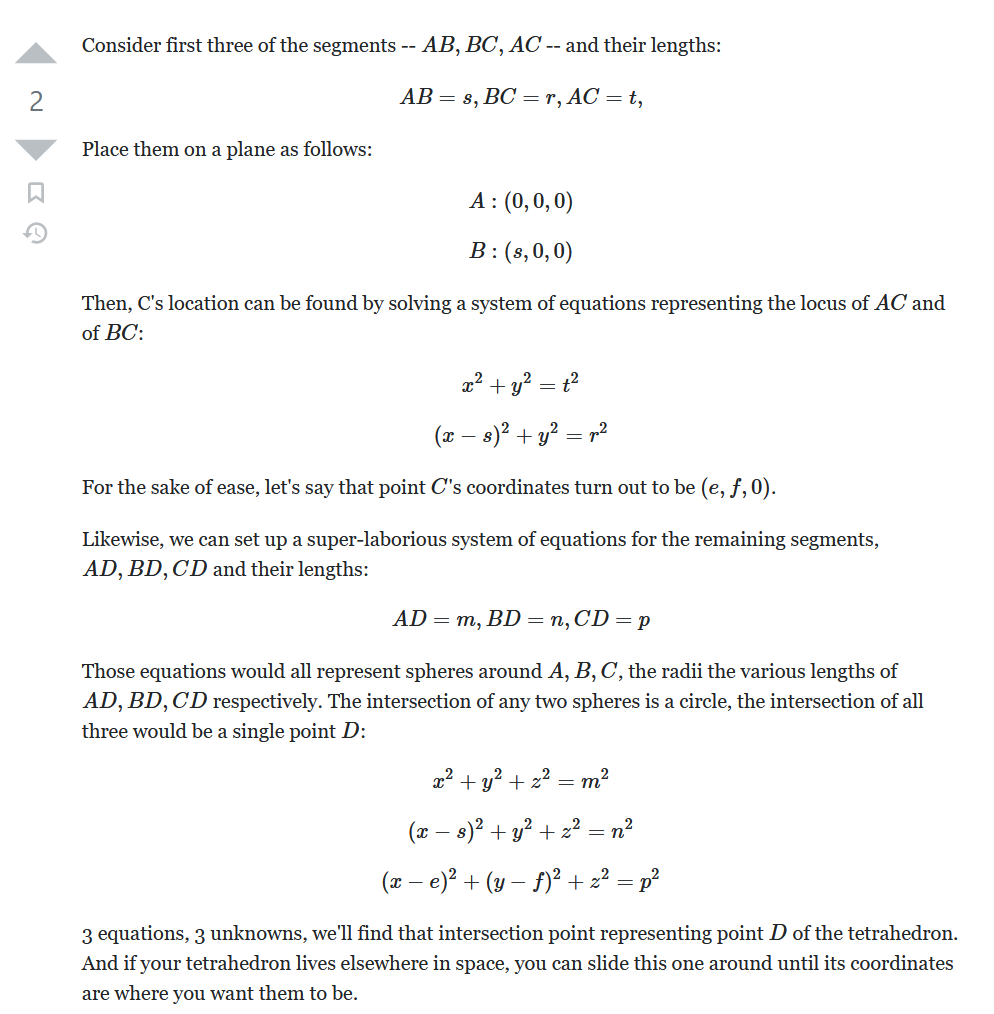

https://www.eng.uc.edu/~beaucag/Classes/Properties/OptionalProjects/CoordinateTransformationCode/Rotate%20about%20an%20arbitrary%20axis%20(3%20dimensions).html

In [ ]:
#http://wiki.gis.com/wiki/index.php/Trilateration



<AxesSubplot:ylabel='Count'>

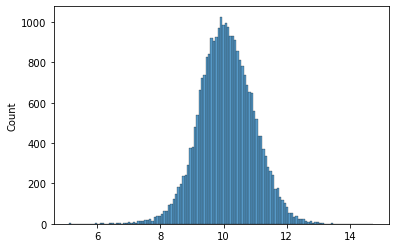

In [34]:
mp_01 = get_midpoint(X,helices_desired=[0,1])
mp_02 = get_midpoint(X,helices_desired=[2,3])
d= np.linalg.norm(mp_02-mp_01,axis=1)
sns.histplot(d)

In [9]:
#still possibly useful

def bi(helices_to_keep, num_helices=4, intraHelixDist=True):
    """Get index values for parts of the distance map"""
    
    #prep indices for distance map
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    
    helix_used = np.array(helices_to_keep,dtype=int)
    
    h_ep = np.array(range(num_ep)).reshape((-1,2)) #generate helix to endpoint mapping
    
    tot_ind = []
    
    if intraHelixDist:
        #get indices of distance map that correspond to each helix, overlap is distances between specified endpoints
        for x in helix_used:
            new_ind = np.intersect1d(mat_ind[h_ep[x]], mat_ind.T[h_ep[x]])
            tot_ind.extend(new_ind)
    
    
    for x in permutations(helix_used,2):
        new_ind = np.intersect1d(mat_ind[h_ep[x[0]]], mat_ind.T[h_ep[x[1]]])
        tot_ind.extend(new_ind)
    
    return np.intersect1d(tot_ind,mat_ind[iu1])

def bi_single(ep_index,num_helices=4, singlePoint=-1):
    
    #prep indices for distance map
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    il1 = np.tril_indices(num_ep, 1)
    tot_ind = []
    
    if singlePoint == -1:
        for x in permutations(ep_index,2):
            new_ind = np.intersect1d(mat_ind[x[0]], mat_ind.T[x[1]])
            tot_ind.extend(new_ind)
    else: 
        for x in (ep_index):
            new_ind = np.intersect1d(mat_ind[x], mat_ind.T[singlePoint])
            tot_ind.extend(new_ind)
    
    upperInd = np.intersect1d(tot_ind,mat_ind[iu1])
    lowerInd = np.intersect1d(tot_ind,mat_ind[il1])
    
    if len(upperInd)>len(lowerInd):
        return upperInd
    else:
        return lowerInd